In [1]:
from sklearn.decomposition import PCA
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


2025-03-20 10:02:35.122023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 10:02:35.123052: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 10:02:35.128266: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 10:02:35.143114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742464955.167880  771061 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742464955.17

In [3]:

import sys
import os
sys.path.append(os.path.abspath("../app"))
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/home/sb/lewagon_london/project_lewagon/stock-stat-replica/data/lewagon-statistical-arbitrage-ae470f7dcd48.json'


In [4]:
from data_query import fetch_NASDAQ100_index
from data_query import fetch_NASDAQ100_all_components
from data_query import fetch_SP500_index
from data_query import fetch_SP500_all_components
from data_query import fetch_ftse100_index
from data_query import fetch_ftse100_all_components
from PCA_function import rolling_pca_weights
from preprocessing import preprocessing_X
from sklearn.decomposition import PCA
from typing import List

In [18]:
index_selected='FTSE100'
if index_selected=='NASDAQ100':
    target_df= fetch_NASDAQ100_index()
    underlying_df=fetch_NASDAQ100_all_components()
elif index_selected=='SP500':
    target_df= fetch_SP500_index()
    underlying_df=fetch_SP500_all_components()
elif index_selected=='FTSE100':
    target_df= fetch_ftse100_index()
    underlying_df=fetch_ftse100_all_components()

n_stocks = 30               # number of stocks used for the replication
window = 30                 # period the trading strat goes
n_pcs = 3   
if 'date' in underlying_df.columns and not underlying_df['date'].empty:
    underlying_df.set_index('date', inplace=True)

# Create log returns to remove stationarity
log_returns = np.log(underlying_df / underlying_df.shift(1))

# Drop NaN values caused by the shift
log_returns = log_returns.dropna()
X_log = log_returns.copy()
stock_log_features = X_log.columns

# Scaling data
scaler = StandardScaler()
scaler.fit(X_log)
X_log = pd.DataFrame(scaler.transform(X_log), columns=stock_log_features, index=log_returns.index)

rep_pf = rolling_pca_weights(X_log, n_stocks, window, n_pcs)

In [19]:
daily_weights_df=rep_pf.copy()
daily_weights_df.index=pd.to_datetime(daily_weights_df.index)
daily_weights_df.index


DatetimeIndex(['2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21',
               '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25',
               '2022-03-28', '2022-03-29',
               ...
               '2025-02-25', '2025-02-26', '2025-02-27', '2025-02-28',
               '2025-03-03', '2025-03-04', '2025-03-05', '2025-03-06',
               '2025-03-07', '2025-03-10'],
              dtype='datetime64[ns]', name='date', length=755, freq=None)

In [20]:
target_df.set_index('date',inplace=True)

In [21]:
df=target_df
df

,FTSE100
date,
2022-02-01,7535.799805
2022-02-02,7583.000000
2022-02-03,7528.799805
2022-02-04,7516.399902
2022-02-07,7573.500000
...,...
2025-03-04,8759.000000
2025-03-05,8755.799805
2025-03-06,8682.799805


In [22]:
# SPREAD CODE:

pca_date = '2024-03-18'

# Filter stocks with values > 0 on the specific date
filtered_columns = daily_weights_df.loc[pca_date][daily_weights_df.loc[pca_date] > 0].index
# replication pf weights taken from output function
rep_pf = daily_weights_df.loc[[pca_date], filtered_columns]

# log returns of rep pf
rep_pf_log_returns_daily = log_returns[rep_pf.columns]

# log return times weights (results)
rep_pf_results = rep_pf_log_returns_daily.mul(rep_pf.iloc[0], axis=1)
rep_pf_results["total_rep_pf"] = rep_pf_results.sum(axis=1)
rep_pf_results

# Calculate log returns FTSE100 / Index    
FTSE_log_return = np.log(df["FTSE100"] / df["FTSE100"].shift(1)).dropna()
FTSE_log_return

# DF of spread
spread_df = pd.DataFrame()  # Create a new DataFrame for the spread
spread_df["spread"] = FTSE_log_return - rep_pf_results["total_rep_pf"]  # Add a column named "spread"
training_spread_df = spread_df.loc[:pca_date].iloc[:-1]  # Data up to the PCA date, excluding the date itself

In [23]:
training_spread_df

,spread
date,
2022-02-02,-0.001915
2022-02-03,0.005052
2022-02-04,0.009731
2022-02-07,0.005202
2022-02-08,-0.002083
...,...
2024-03-11,0.00242
2024-03-12,-0.002849
2024-03-13,0.005767


Epoch 1/100


/home/sb/.pyenv/versions/3.10.6/envs/stockify_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 1.0156 - val_loss: 1.4163
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.8744 - val_loss: 1.4137
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.9086 - val_loss: 1.4188
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.9628 - val_loss: 1.4298
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.8900 - val_loss: 1.4327
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.8294 - val_loss: 1.4249
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.9087 - val_loss: 1.4311
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.9859 - val_loss: 1.4275
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.7855 - val_loss: 1.4316
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.9017 - val_loss: 1.4356
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.9651 - val_loss: 1.4375
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.0

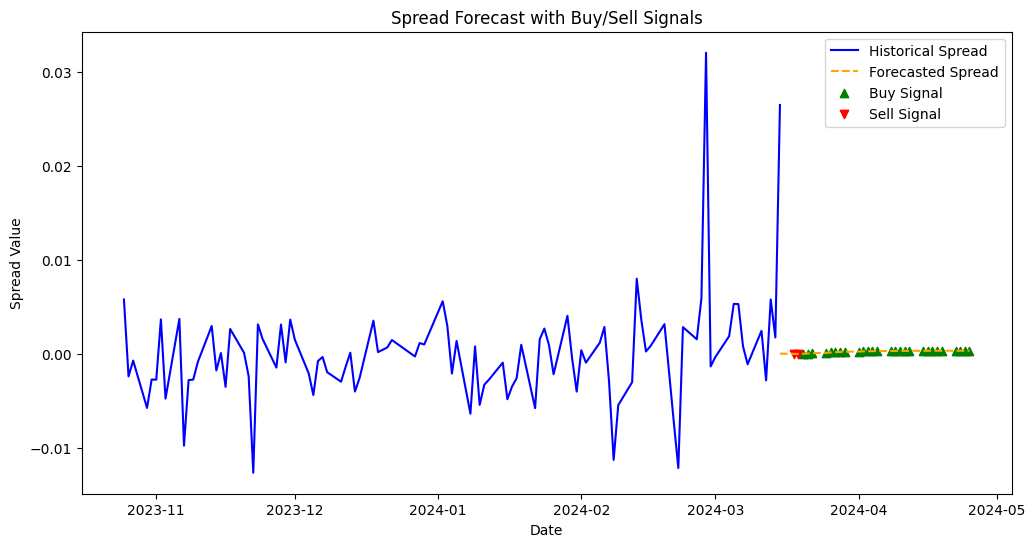

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler


spread_values = spread_values = training_spread_df
df=training_spread_df

train_size = int(len(spread_values) * 0.8)
train_spread, test_spread = spread_values[:train_size], spread_values[train_size:]

scaler = StandardScaler()
train_spread_scaled = scaler.fit_transform(train_spread)
test_spread_scaled = scaler.transform(test_spread)

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_spread_scaled, sequence_length)
X_test, y_test = create_sequences(test_spread_scaled, sequence_length)


model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Forecast future values
future_predictions = []
last_sequence = test_spread_scaled[-sequence_length:].reshape(1, sequence_length, 1)

for _ in range(30):  # Predict next 30 days
    pred = model.predict(last_sequence)[0, 0]
    future_predictions.append(pred)
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred

# Inverse transform predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create future dates (skip weekends)
future_dates = pd.date_range(df.index[-1], periods=30, freq="B")  # 'B' for business days

# Generate Buy/Sell signals (Simple: Buy if increasing, Sell if decreasing)
buy_signals, sell_signals = [], []
for i in range(1, len(future_predictions)):
    if future_predictions[i] > future_predictions[i-1]:  # Upward trend
        buy_signals.append((future_dates[i], future_predictions[i, 0]))
    else:  # Downward trend
        sell_signals.append((future_dates[i], future_predictions[i, 0]))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df["spread"].values[-100:], label="Historical Spread", color="blue")
plt.plot(future_dates, future_predictions, label="Forecasted Spread", color="orange", linestyle="dashed")
plt.scatter(*zip(*buy_signals), color="green", marker="^", label="Buy Signal")
plt.scatter(*zip(*sell_signals), color="red", marker="v", label="Sell Signal")

plt.xlabel("Date")
plt.ylabel("Spread Value")
plt.title("Spread Forecast with Buy/Sell Signals")
plt.legend()
plt.show()
